<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9123_DL/blob/main/HW/HW6/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A simple GAN
In this problem, the goal is to train and visualize the outputs of a simple Deep
Convolutional GAN (DCGAN) to generate realistic-looking (but fake) images of clothing.

* a. Use the FashionMNIST training dataset to train the DCGAN. APIs for downloading it
are available in both PyTorch and TensorFlow. Images are grayscale and size 28 × 28.
* b. Use the following discriminator architecture (kernel size = 5 × 5 with stride = 2 in both
directions):
** 2D convolutions (1 × 28 × 28 → 64 × 14 × 14 → 128 × 7 × 7)
** each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed
by Dropout with parameter 0.3.
** a dense layer that takes the flattened output of the last convolution and maps it to a
scalar.

Here is a [link](https://discuss.pytorch.org/t/how-to-keep-the-shape-of-input-and-output-same-when-dilation-conv/14338/3) that discusses how to appropriately choose padding and stride values in order to
desired sizes.

* c. Use the following generator architecture (which is essentially the reverse of a standard
discriminative architecture). You can use the same kernel size. Construct:
** a dense layer that takes a unit Gaussian noise vector of length 100 and maps it to a
vector of size 7 ∗ 7 ∗ 256. No bias terms.
** several transpose 2D convolutions (256 × 7 × 7 → 128 × 7 × 7 → 64 × 14 × 14 →
1 × 28 × 28). No bias terms.
** each convolutional layer (except the last one) is equipped with Batch Normalization
(batch norm), followed by Leaky ReLU with slope 0.3. The last (output) layer is
equipped with tanh activation (no batch norm).
* d. Use the cross-entropy loss for training both the generator and the discriminator. Use the
Adam optimizer with learning rate $10^{-4}$. 
* e. Train it for 50 epochs. You can use minibatch sizes of 16, 32, or 64. Training may take
several minutes (or even up to an hour), so be patient! Display intermediate images
generated after T = 10, T = 30, and T = 50 epochs. If the random seeds are fixed
throughout then you should get results of the following quality.
![WeChat Screenshot_20210501224441](https://user-images.githubusercontent.com/68700549/116800418-dcd71480-aace-11eb-9f80-41f4ede3ec0c.png)
* f. Report loss curves for both the discriminator and the generator loss over all epochs, and
qualitatively comment on their behavior.

https://debuggercafe.com/implementing-deep-convolutional-gan-with-pytorch/

## Import packages

In [147]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Load the dataset

In [148]:
## Creates a series of transformation to prepare the dataset. We convert images to tensor
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])

## Load the dataset
train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)

## Data Loader
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw




Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Explore dataset
We have 60,000 data  for training and 10,000 data for testing

In [ ]:
print(train_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [ ]:
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /root/.pytorch/F_MNIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


### Visualize the image

In [ ]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


the label is: 3


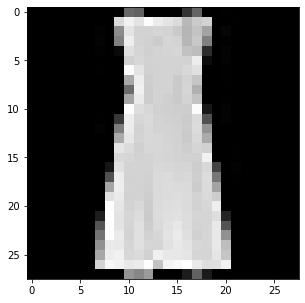

In [ ]:
rand_index = np.random.randint(0,64)
fig = plt.figure(figsize=(15,5))
plt.imshow(images[rand_index].reshape((28,28)),cmap='gray')
print("the label is: "+ str(int(labels[rand_index])))

## Build discriminator architecture
kernel size = 5 × 5 with stride = 2 in both
directions:

* 2D convolutions (1 × 28 × 28 → 64 × 14 × 14 → 128 × 7 × 7)
* each convolutional layer is equipped with a Leaky ReLU with slope 0.3, followed
by Dropout with parameter 0.3.
* a dense layer that takes the flattened output of the last convolution and maps it to a
scalar.

In [149]:
def discriminator_model():
  model = nn.Sequential(
      nn.Conv2d(1,64,5,2,padding=2),
      nn.LeakyReLU(0.3),
      nn.Dropout(0.3),

      nn.Conv2d(64,128,5,2,padding=2),
      nn.LeakyReLU(0.3),
      nn.Dropout(0.3),

      nn.Flatten(),
      nn.Linear(6272,1)
  )
  return model

In [150]:
from torchsummary import summary
discriminator = discriminator_model()
summary(discriminator,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           1,664
         LeakyReLU-2           [-1, 64, 14, 14]               0
           Dropout-3           [-1, 64, 14, 14]               0
            Conv2d-4            [-1, 128, 7, 7]         204,928
         LeakyReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
           Flatten-7                 [-1, 6272]               0
            Linear-8                    [-1, 1]           6,273
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.81
Estimated Total Size (MB): 1.29
----------------------------------------------------------------


## Build generator

* c. Use the following generator architecture (which is essentially the reverse of a standard
discriminative architecture). You can use the same kernel size. Construct:
** a dense layer that takes a unit Gaussian noise vector of length 100 (This means initial input.) and maps it to a
vector of size 7 ∗ 7 ∗ 256.  No bias terms.
** several transpose 2D convolutions (256 × 7 × 7 → 128 × 7 × 7 → 64 × 14 × 14 →
1 × 28 × 28). No bias terms.
** each convolutional layer (except the last one) is equipped with Batch Normalization
(batch norm), followed by Leaky ReLU with slope 0.3. The last (output) layer is
equipped with tanh activation (no batch norm).

In [151]:
def generator_model():
  model = nn.Sequential(
      nn.ConvTranspose2d(100,256,7,1,0,bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.3),

      nn.ConvTranspose2d(256,128,5,1,2,bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.3),

      nn.ConvTranspose2d(128,64,6,2,2,bias=False),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.3),

      nn.ConvTranspose2d(64,1,6,2,2,bias=False),
      nn.Tanh()
  )
  return model

In [152]:
generator = generator_model()
summary(generator,(100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 7, 7]       1,254,400
       BatchNorm2d-2            [-1, 256, 7, 7]             512
         LeakyReLU-3            [-1, 256, 7, 7]               0
   ConvTranspose2d-4            [-1, 128, 7, 7]         819,200
       BatchNorm2d-5            [-1, 128, 7, 7]             256
         LeakyReLU-6            [-1, 128, 7, 7]               0
   ConvTranspose2d-7           [-1, 64, 14, 14]         294,912
       BatchNorm2d-8           [-1, 64, 14, 14]             128
         LeakyReLU-9           [-1, 64, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           2,304
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 2,371,712
Trainable params: 2,371,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [117]:
latent = torch.randn(1,100, 1, 1)

In [136]:
im = generator(latent)

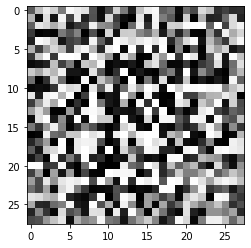

In [145]:
plt.imshow(im[0, 0, :, :].detach(),cmap='gray')

## Loss and optimizers
Use the cross-entropy loss for training both the generator and the discriminator. Use the
Adam optimizer with learning rate $10^{-4}$. 

In [157]:
loss = nn.CrossEntropyLoss()
learning_rate = 1e-4

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
def g_loss(fake_output):
  
  return loss()

In [ ]:
def d_loss(real_output, fake_output):
  
  return total_loss

## Train
e. Train it for 50 epochs. You can use minibatch sizes of 16, 32, or 64. Training may take several minutes (or even up to an hour), so be patient! Display intermediate images generated after T = 10, T = 30, and T = 50 epochs. 

## Loss
f. Report loss curves for both the discriminator and the generator loss over all epochs, and qualitatively comment on their behavior.

## Reference

https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582